## 2 практическое задание по DL

Выполнила: Гайфутдинова Фарида, 317 группа

Тема: Классификация «дотюниным» трансформером

Выбранные архитектуры трансформеров: **BERT, ALBERT**


Задача: Взять несколько предобученных трансоформеров, выбрать одну любую задачу классификации текстов, провести дообучение трансформеров. Разобраться, как их лучше дообучать для получения максимального качества. Для получения максимального качества проводилось варьирование следующих параметров:

1. Batch size
2. LR
3. Tokenizer max length

Датасет: "Twitter US Airline Sentiment"

# Использование трансформера

* на базе https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/
* https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [ ]:
#!g1.1
%pip install transformers

In [ ]:
#!g1.1
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg', 'pdf']
warnings.filterwarnings('ignore')
from tqdm import tqdm
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
import time
import datetime
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Загрузка датасета + его предобработка

In [ ]:
#!g1.1
df = pd.read_csv('./Tweets.csv')
df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Видим, что метки в неправильном формате, переведем их в нужный - численный.

In [ ]:
#!g1.1
def str_to_dig(label):
    if label == 'negative':
        return 0
    elif label == 'positive':
        return 2
    else:
        return 1

In [ ]:
#!g1.1
df['airline_sentiment'] = df['airline_sentiment'].apply(lambda x: str_to_dig(x))
df = df[:8000]
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,1,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,2,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,1,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,0,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,0,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Описание датасета

Датасет представляет из себя коллекцию твитов о 6 американских авиакомпаниях. Твиты могут иметь позитивный, негативный, а также нейтральный окрас. (2, 0, 1 соответсвенно)

# BERT
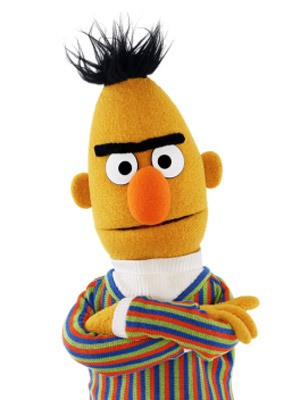


## Архитектура BERT

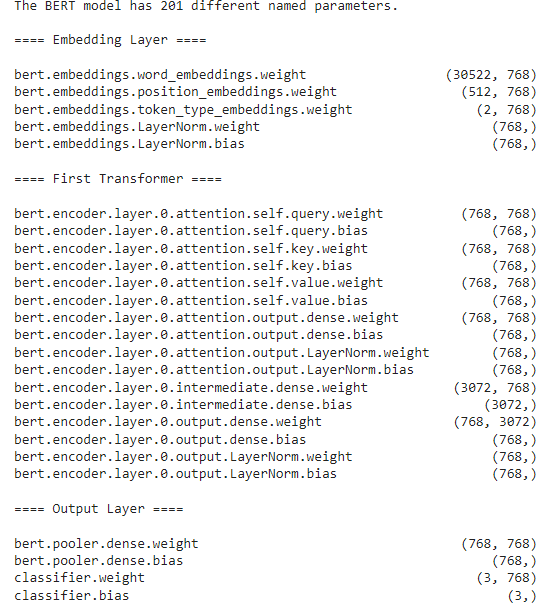

In [ ]:
#!g1.1
from transformers import BertForSequenceClassification, AdamW, BertConfig


model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3,  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()


In [ ]:
#!g1.1
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


Loading BERT tokenizer...


In [ ]:
#!g1.1
sentences = df['text'].to_list()

In [ ]:
#!g1.1
labels = df['airline_sentiment'].to_list()

In [ ]:
#!g1.1
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  67


In [ ]:
#!g1.1
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2221: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/kernel/lib/python3.8/site-packages/ml_kernel/ignored_keyboard_interrupt.py:16: UserWarning: Kernel cannot be interrupted during state load
  warnings.warn(self._warn_message)


Original:  @VirginAmerica What @dhepburn said.
Token IDs: tensor([  101,  1030,  6261, 14074, 14735,  2054,  1030, 28144, 13699,  8022,
         2056,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


# Разбиваем данные на обучение, валидацию и тест

На валидации подбираем гиперпараметры, на тесте сделаем итоговое сравнение

In [ ]:
#!g1.1
import random
from torch.utils.data import TensorDataset, random_split

# Calculate the number of samples to include in each set.
train_and_val_size = int(0.8 * len(input_ids))
train_size = int(0.8 * train_and_val_size)
val_size = train_and_val_size - train_size
test_size = len(input_ids) - train_and_val_size

train_dataset = TensorDataset(input_ids[:train_size], 
                              attention_masks[:train_size], 
                              labels[:train_size])

val_dataset = TensorDataset(input_ids[train_size + 1:train_and_val_size ], 
                            attention_masks[train_size + 1:train_and_val_size], 
                            labels[train_size + 1:train_and_val_size])

test_dataset = TensorDataset(input_ids[train_and_val_size + 1:], 
                             attention_masks[train_and_val_size + 1:], 
                             labels[train_and_val_size + 1:])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

5,120 training samples
1,280 validation samples
1,600 test samples


# Создаем dataloader

In [ ]:
#!g1.1
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
#!g1.1
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
#!g1.1
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 10

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [ ]:
#!g1.1
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [ ]:
#!g1.1
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))



In [ ]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Обучаем сеть

Вспомогательная функция для обучения сети и подсчета качества находится здесь: 

# Batch size

In [ ]:
#!g1.1
batch_size_list = [16, 32, 48, 64]
test_info = []
epochs = 12

for batch_size in batch_size_list:
    print(f'BATCH_SIZE = {batch_size}')
    train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size
        )


    validation_dataloader = DataLoader(
                val_dataset, 
                sampler = SequentialSampler(val_dataset), 
                batch_size = batch_size
            )
    
    optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

    total_steps = len(train_dataloader) * epochs

    
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    test_data = train(train_dataloader, validation_dataloader, epochs,
                     optimizer, scheduler)
    test_info.append(test_data)

### Статистика

Здесь и везде далее приведены результаты работы сети на валидационной выборке

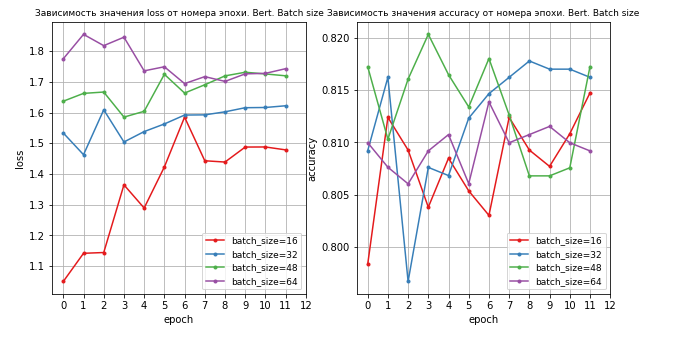

## Вывод:


Видим, что как и написано в документации к данной сети, с дефолтными параметрами batch_size = 32 подходит лучше всего. Будем далее использовать его.

# Tokenizer max length

Вспомогательные функци для создания датасетов и даталоадеров находятся здесь:

In [ ]:
#!g1.1
import warnings
warnings.filterwarnings("ignore")
max_l = [20, 40, 60, 80]

test_info = []
epochs = 12

for lenn in max_l:
    print(f'TOKENIZER MAX LENGTH = {lenn}')
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 3,  
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    model.cuda()
    sentences = df['text'].to_list()
    labels = df['airline_sentiment'].to_list()
    input_ids, attention_masks, labels = get_tokenizer(sentences, 
                                                   labels, lenn)
    train_dataloader, validation_dataloader, test_dataloader = get_loaders(input_ids, 
                                                                           attention_masks, 
                                                                           labels)
    
    optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    test_data = train(train_dataloader, validation_dataloader, epochs,
                     optimizer, scheduler, model)
    test_info.append(test_data)

## Статистика

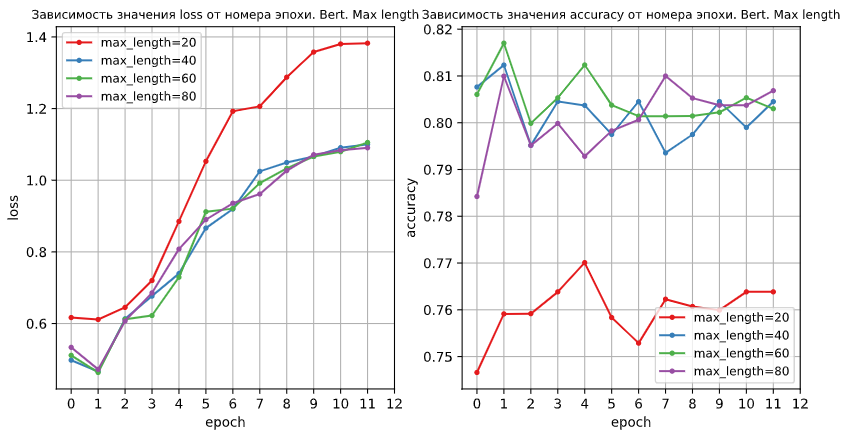

## Вывод:

Можно заметить, что везде происходит переобучение, необходимо контроллировать число эпох, поэтому далее мы уменьшим его до 5. Среди значение максимальной длины токенизации 40, 60 и 80 показывают примерно одинаковый результат, но можно заметить, что чем больше это число, тем дольше модель тартит времени на 1 эпоху, возмем оптимальное значение 60.

# Learning rate

In [ ]:
sentences = df['text'].to_list()
labels = df['airline_sentiment'].to_list()
input_ids, attention_masks, labels = get_tokenizer(sentences, 
                                                  labels, 60)
train_dataloader, validation_dataloader, test_dataloader = get_loaders(input_ids, 
                                                                        attention_masks, 
                                                                        labels)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
lr_list = [5e-3, 5e-4, 5e-5]

test_info = []
epochs = 5

for lr in lr_list:
    print(f'LEARNING RATE = {lr}')
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 3,  
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    model.cuda()
    
    optimizer = AdamW(model.parameters(),
                  lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    test_data = train(train_dataloader, validation_dataloader, epochs,
                     optimizer, scheduler, model)
    test_info.append(test_data)

## Статистика

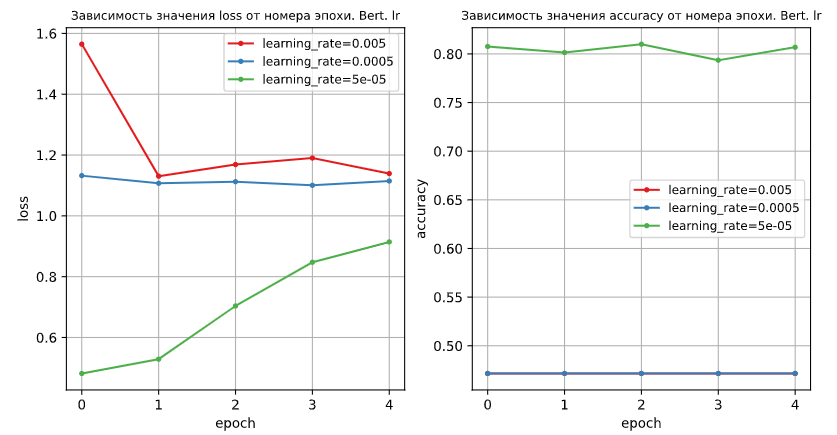

## Вывод:

Слишком большой шаг не стоит брать, так как с ним наша сеть очень плохо обучается. Мы перепрыгиваем через минимумы функции потерь. Возьмем learning_rate=5e-05

# Итоговое сравнение

In [ ]:
res = []
test_info = []
epochs = 13

#Base
print(f"Base model:")
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3,  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

input_ids, attention_masks, labels = get_tokenizer(sentences, 
                                                      labels, 64)
train_dataloader, validation_dataloader, test_dataloader = get_loaders(input_ids, 
                                                                        attention_masks, 
                                                                        labels, 32)

model.cuda()

optimizer = AdamW(model.parameters(),
              lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
              eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
            )

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
test_data = train(train_dataloader, test_dataloader, epochs,
                  optimizer, scheduler, model)
res.append(test_data)

print(f"Result model:")

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3,  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

input_ids, attention_masks, labels = get_tokenizer(sentences, 
                                                      labels, 60)
train_dataloader, validation_dataloader, test_dataloader = get_loaders(input_ids, 
                                                                        attention_masks, 
                                                                        labels, 32)

model.cuda()

optimizer = AdamW(model.parameters(),
              lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
              eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
            )

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
test_data = train(train_dataloader, test_dataloader, epochs,
                  optimizer, scheduler, model)
res.append(test_data)

## Статистика. BERT.

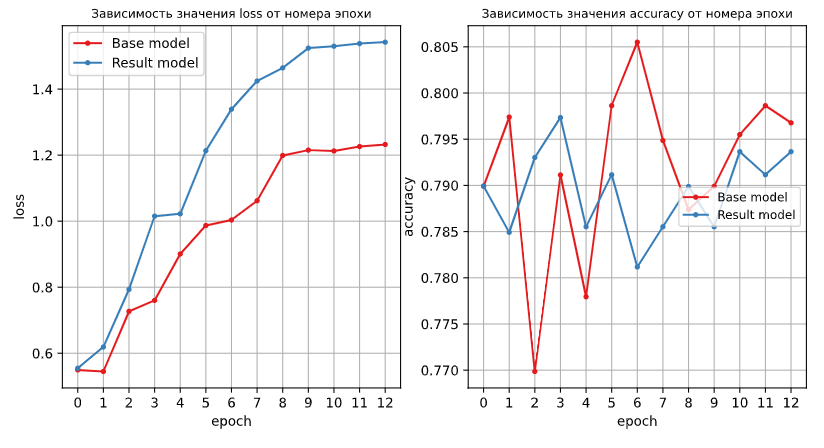



## Выводы:

Заметим, что практически все параметры при подборе лучшего значения совпали с дефолтным (или находятся не так далеко от него), поэтому точность модели не возросла. Возможно, мы взяли слишком мало эпох или маленький датасет (произошло переобучение на нем).

# ALBERT

## Архитектура сети

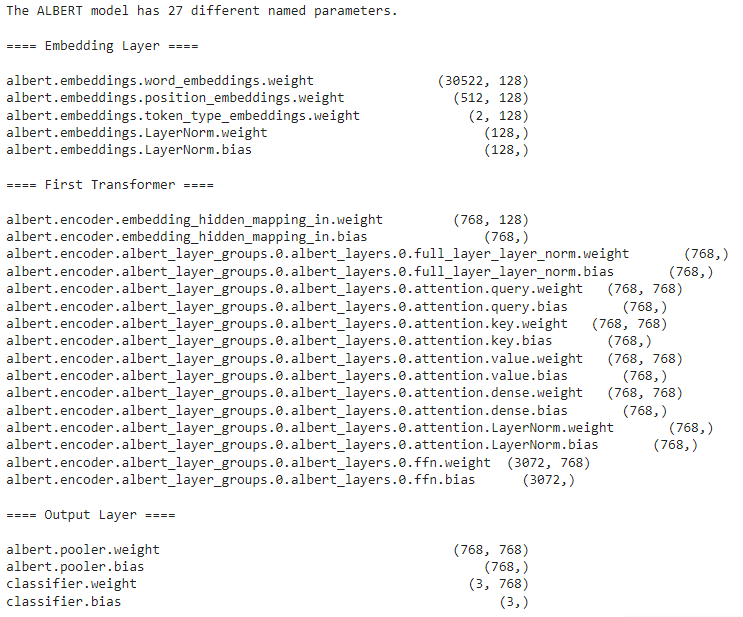

In [ ]:
model = AlbertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3,  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

В этот раз возьмем выборку чуть поменьше и побольше эпох, так как она чуть медленнее обучается. (запускала BERT на датасете такого же размера)

# Batch size

In [ ]:
sentences = df['text'].to_list()
labels = df['airline_sentiment'].to_list()
input_ids, attention_masks, labels = get_tokenizer(sentences, 
                                                  labels, 64)


In [ ]:
import warnings
warnings.filterwarnings("ignore")
batch_size_list = [16, 32, 64]

test_info = []
epochs = 17

for bs in batch_size_list:
    print(f'BATCH SIZE = {bs}')
    model = AlbertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 3,  
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    model.cuda()
    train_dataloader, validation_dataloader, test_dataloader = get_loaders(input_ids, 
                                                                        attention_masks, 
                                                                        labels, bs)
    
    optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    test_data = train(train_dataloader, validation_dataloader, epochs,
                     optimizer, scheduler, model)
    test_info.append(test_data)

## Статистика

Опечатка - это ALBERT, а не BERT

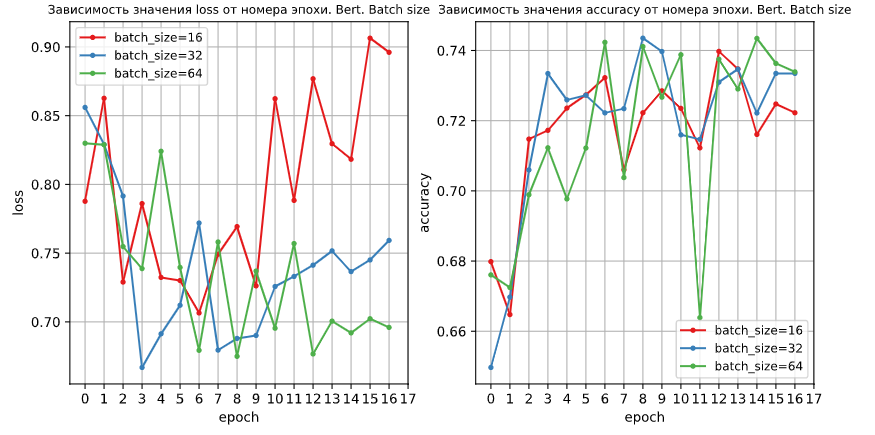

Заметим, что при размере батча 16 и 32 происходит переобучение, поэтому возьмем для дальнейших экспериментов batch_size=16.

# Tokenizer max length

In [ ]:
import warnings
warnings.filterwarnings("ignore")
max_l = [40, 60, 80]

test_info = []
epochs = 17

for lenn in max_l:
    print(f'TOKENIZER MAX LENGTH = {lenn}')
    model = AlbertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 3,  
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    model.cuda()
    sentences = df['text'].to_list()
    labels = df['airline_sentiment'].to_list()
    input_ids, attention_masks, labels = get_tokenizer(sentences, 
                                                      labels, lenn)
    train_dataloader, validation_dataloader, test_dataloader = get_loaders(input_ids, 
                                                                           attention_masks, 
                                                                           labels, 64)
    
    optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    test_data = train(train_dataloader, validation_dataloader, epochs,
                     optimizer, scheduler, model)
    test_info.append(test_data)

## Статистика

Опечатка - это ALBERT, а не BERT

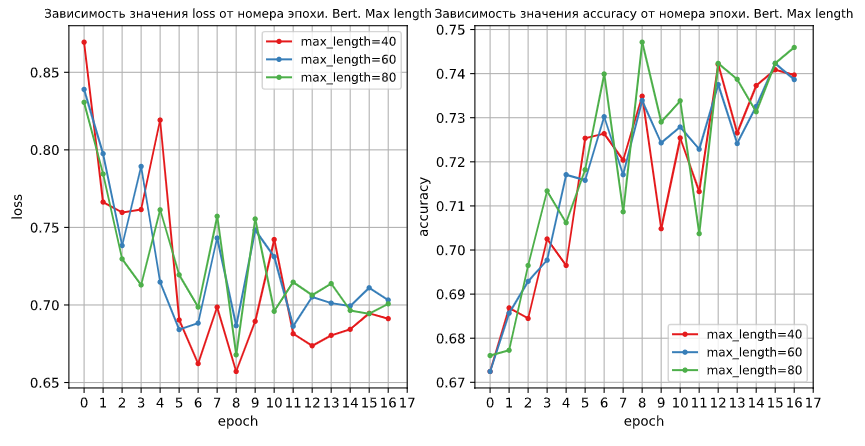

## Вывод:


Здесь все значения максимальной длины токенизации ведут себя примерно одинаково, возьмем среднее из них - 60 

# Learning rate

In [ ]:
lr_list = [5e-3, 5e-4, 5e-5]

test_info = []
epochs = 17

for lr in lr_list:
    print(f'LEARNING RATE = {lr}')
    model = AlbertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 3,  
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    model.cuda()
    
    optimizer = AdamW(model.parameters(),
                  lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    test_data = train(train_dataloader, validation_dataloader, epochs,
                     optimizer, scheduler, model)
    test_info.append(test_data)

## Статистика

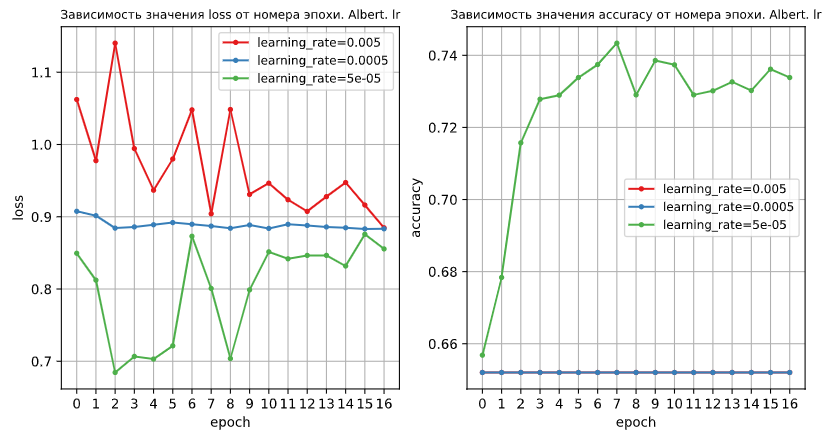

# Вывод:


Аналогичная ситуация, как была с Bert-ом, слишком большой шаг нам не подходит, сеть не обучается. Возьмем learning_rate=5e-05

# Итоговое сравнение

In [ ]:
res = []
test_info = []
epochs = 17

#Base
print(f"Base model:")
model = AlbertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3,  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

input_ids, attention_masks, labels = get_tokenizer(sentences, 
                                                      labels, 64)
train_dataloader, validation_dataloader, test_dataloader = get_loaders(input_ids, 
                                                                        attention_masks, 
                                                                        labels, 32)

model.cuda()

optimizer = AdamW(model.parameters(),
              lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
              eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
            )

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
test_data = train(train_dataloader, test_dataloader, epochs,
                  optimizer, scheduler, model)
res.append(test_data)

print(f"Result model:")

model = AlbertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3,  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

input_ids, attention_masks, labels = get_tokenizer(sentences, 
                                                      labels, 60)
train_dataloader, validation_dataloader, test_dataloader = get_loaders(input_ids, 
                                                                        attention_masks, 
                                                                        labels, 64)

model.cuda()

optimizer = AdamW(model.parameters(),
              lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
              eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
            )

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
test_data = train(train_dataloader, test_dataloader, epochs,
                  optimizer, scheduler, model)
res.append(test_data)

## Статистика. ALBERT

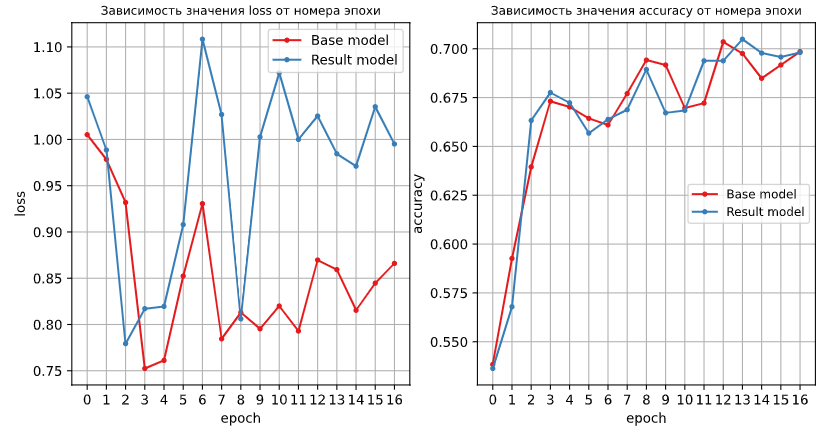

# Вывод:

Можно сделать вывод опять же из-за небольших отличий в значениях гиперпараметров качество модели не изменилось. Также ,возможно, мы переобучаемся из-за маленького размера датасета.

Или такая ситуация произошла из-за того, что мы не перемешивали датасет перед делением.